# Prepare all data for workshop

In [82]:
%matplotlib inline

import requests
import pandas as pd
import geopandas as gpd
from qgrid import show_grid

def download(url, dest):
    try:
        open(dest)
    except:
        r = requests.get(url)
        with open(dest, 'wb') as fo:
            fo.write(r.content)
            fo.close()
    return dest

## AirBnb data for Rio

In [81]:
%%time

url = ('http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/'\
       '2019-02-11/data/listings.csv.gz')

print(f"File downloaded to: {download(url, '../data/listings.csv.gz')}")

File downloaded to: ../data/listings.csv.gz
CPU times: user 1.68 s, sys: 1.57 s, total: 3.25 s
Wall time: 60 s


## Municipality data for Belo Horizonte

> [`ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2017/Brasil/BR/`](ftp://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2017/Brasil/BR/)

* Read in Municipality geoms

In [84]:
mun_geo = gpd.read_file('../raw_data/br_municipios/BRMUE250GC_SIR.shp')
mun_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
NM_MUNICIP    5572 non-null object
CD_GEOCMU     5572 non-null object
geometry      5572 non-null object
dtypes: object(3)
memory usage: 130.7+ KB


* Read Metro areas and keep BH

In [5]:
met_geo = gpd.read_file('../raw_data/br_mesorregioes/BRMEE250GC_SIR.shp')
met_geo.head()

,NM_MESO,CD_GEOCME,geometry
0,AGRESTE ALAGOANO,2702,POLYGON ((-36.43700367299986 -9.21210013399995...
1,AGRESTE PARAIBANO,2503,POLYGON ((-36.07376266499988 -6.41487171999999...
2,AGRESTE PERNAMBUCANO,2603,POLYGON ((-35.4917628389999 -7.528785962000018...
3,AGRESTE POTIGUAR,2403,POLYGON ((-35.84022475199999 -5.23458626699999...
4,AGRESTE SERGIPANO,2802,POLYGON ((-37.05739916499988 -10.1810894849999...


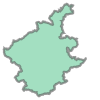

In [19]:
bh = met_geo.loc[met_geo.query("NM_MESO == 'METROPOLITANA DE BELO HORIZONTE'")\
                        .index[0], 
                 'geometry']
bh

* Keep municipalities within BH

In [38]:
%time bh_muns = mun_geo[mun_geo.within(bh.buffer(0.01))]

CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.88 s


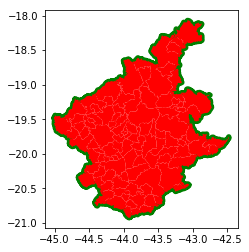

In [39]:
ax = met_geo.query("NM_MESO == 'METROPOLITANA DE BELO HORIZONTE'")['geometry']\
            .plot(facecolor='none', edgecolor='green', linewidth=5)
bh_muns.plot(ax=ax, color='red')

* Load wage

> [`http://dataviva.info/en/data/`](http://dataviva.info/en/data/)

In [41]:
wag = pd.read_csv('../raw_data/rais-2014-municipalities.csv.bz2')
wag.head()

,Year,BRA ID,Total Monthly Wages,Total Jobs,Total Establishments,Average Monthly Wage,Average age,Industry Diversity,Effective Industry Diversity,Occupation Diversity,...,Average age.1,Industry Diversity.1,Effective Industry Diversity.1,Occupation Diversity.1,Effective Occupation Diversity.1,Nominal Wage Growth (1 year).1,Nominal Wage Growth (5 year).1,Nominal Employee Growth (1 year).1,Nominal Employee Growth (5 year).1,Gini coefficient.1
0,2014,1ac000000,10643231.99,8154,745,1305.28,33.953,169,35.497,246,...,33.953,169,35.497,246,50.039,1.197,0.012,0.368,0.005,NaN
1,2014,1ac000001,1411346.09,908,44,1554.35,35.917,27,3.596,76,...,35.917,27,3.596,76,24.542,1.717,0.021,0.747,0.008,NaN
2,2014,1ac000002,1134941.27,934,12,1215.14,34.989,8,1.205,42,...,34.989,8,1.205,42,9.243,0.602,0.029,0.243,0.023,NaN
3,2014,1ac000003,528501.41,446,12,1184.98,38.863,9,1.334,54,...,38.863,9,1.334,54,11.825,0.389,0.009,-0.049,0.012,NaN
4,2014,1ac000004,1086224.59,732,12,1483.91,38.120,9,1.244,31,...,38.120,9,1.244,31,8.107,1.060,0.049,0.107,0.012,NaN


* Load crosswalk for IDs

In [70]:
cw = pd.read_csv('../raw_data/dataviva-help-locations.csv', index_col='ID')\
       .rename(lambda s: s.lower())

* Join geoms to wages

In [71]:
db = bh_muns.join(wag.set_index('BRA ID')\
                     .rename(cw['ID IBGE']),
                  on='CD_GEOCMU')\
            .loc[:, ['NM_MUNICIP',
                     'CD_GEOCMU',
                     'Total Monthly Wages',
                     'Total Jobs',
                     'Total Establishments',
                     'Average Monthly Wage',
                     'Industry Diversity',
                     'geometry']]
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 105 entries, 176 to 5484
Data columns (total 8 columns):
NM_MUNICIP              105 non-null object
CD_GEOCMU               105 non-null object
Total Monthly Wages     105 non-null float64
Total Jobs              105 non-null int64
Total Establishments    105 non-null int64
Average Monthly Wage    105 non-null float64
Industry Diversity      105 non-null int64
geometry                105 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 12.4+ KB


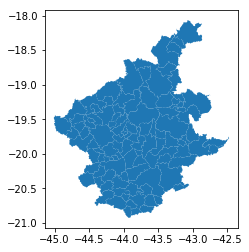

In [85]:
db.plot()

In [88]:
db.to_file('../data/bh.gpkg', driver='GPKG')

## Population

This section assumes the machine has access to the official [GHSL files](http://data.jrc.ec.europa.eu/dataset/jrc-ghsl-ghs_pop_gpw4_globe_r2015a/resource/8a2a1e7c-6a68-4e8c-9518-a648c77a9fde).

* Write BH polygon out

In [78]:
gpd.GeoSeries({'BH': bh}, crs=met_geo.crs).to_file('bh.gpkg', driver='GPKG')

* Specific imports

In [79]:
import numpy as np
import rasterio as rio
from rasterio.mask import mask as riomask
from rasterio.plot import show as rioshow
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt

* Connect to raster

In [11]:
path = ('/home/jovyan/host/Data/GHSL/dat/'\
        'GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0/'\
        'GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0/'\
        'GHS_POP_GPW42015_GLOBE_R2015A_54009_250_v1_0.tif')
src = rio.open(path)

In [12]:
src.crs

CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]')

* BH Polygon

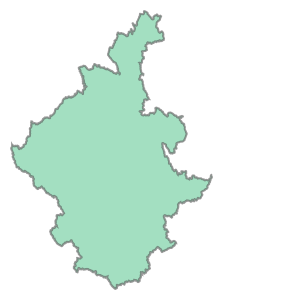

In [13]:
poly = gpd.read_file('bh.gpkg')\
          .to_crs(src.crs)\
          .loc[0, 'geometry']
poly

* Extract

In [16]:
out_image, out_transform = riomask(src, [poly], crop=True)
out_mask = np.ma.masked_equal(out_image, out_image.min())

In [34]:
out_mask

masked_array(
  data=[[[--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=-3.4028235e+38,
  dtype=float32)

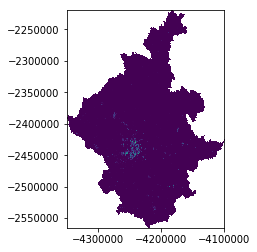

In [33]:
rioshow(out_mask, transform=out_transform)

* Write out into a TIFF file

In [42]:
out_mask[0, :, :].shape

(1383, 1001)

In [41]:
masked_file = rio.open('bh_pop.tif', 'w', driver='GTiff',
                       height=out_mask.shape[1], width=out_mask.shape[2],
                       count=out_mask.shape[0], dtype=out_mask.dtype,
                       crs=src.crs, transform=out_transform)

In [43]:
masked_file.write(out_mask[0, :, :], 1)

In [44]:
masked_file.close()

In [45]:
!du -hs bh_pop.tif

5.3M	bh_pop.tif


---


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Geographic Data Science with Python - UFMG'19</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/darribas/gds_ufmg19" property="cc:attributionName" rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.
